# Few Line Changes to Run on GPU

Let see the example how you can easily in a few lines of code switch calculations from CPU to GPU device.

Please look on the original example.
We call the NumPy library and allocate 2 arrays on the Host (CPU) device, all future calculations will be performed as well on the allocated Host(CPU) device.

In [4]:
# Original CPU script

# Call numpy library
import numpy as np

# Data alocated on the CPU device
x = np.array ([[1, 1], [1, 1]])
y = np.array ([[1, 1], [1, 1]])

# Compute performed on the CPU device, where data is allocated
%timeit res = np.matmul(x, y)

print ("res = ", res)

1 µs ± 8.64 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
res =  [[2 2]
 [2 2]]


Now let's try to modify our code in a way when all calculations occur on the GPU device.
To do it, you need just to switch to the dpnp library and see on the result.

In [15]:
# Modified XPU script

# Drop-in replacement via single line change
import dpnp as np

# Data alocated on default SYCL device
x = np.array([[1, 1], [1, 1]])
y = np.array([[1, 1], [1, 1]])

# Compute performed on the device, where data is allocated
%timeit res = np.matmul(x, y)


print ("Array x is located on the device:", x.device)
print ("Array y is located on the device:", y.device)
print ("res is located on the device:", res.device)
print ("res = ", res)

201 µs ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Array x is located on the device: Device(level_zero:gpu:0)
Array y is located on the device: Device(level_zero:gpu:0)
res is located on the device: Device(level_zero:gpu:0)
res =  [[2 2]
 [2 2]]


As you may see changing only one line of code help us to perform all calculations on the GPU device.
In this example np.array() creates an array on the default SYCL* device, which is "gpu" on systems with integrated or discrete GPU (it is "host" on systems that do not have GPU). The queue associated with this array is now carried with x and y, and np.matmul(x, y) will do matrix product of two arrays x and y, and respective pre-compiled kernel implementing np.matmul() will be submitted to that queue. The result res will be allocated on the device array associated with that queue too.

Now let's make a few improvements in our code and see how we can control and specify exact device on which we want to perform our calculations and which USM memory type to use.

In [6]:
# Modified XPU script
import dpnp as np

# Using filter selector strings one can finely specify root devices. USM memory type is default(device)
x = np.array([[1, 1], [1, 1]], device = "level_zero:gpu:0")
# Default device (Level0, GPU0), USM memory type explicitely set to shared
y = np.array([[1, 1],[1, 1]], usm_type = "shared")

%timeit res = np.matmul(x, y)

print ("Array x is located on the device:", x.device)
print ("Array y is located on the device:", y.device)
print ("res is located on the device:", res.device)
print ("res = ", res)

Array x is located on the device: Device(level_zero:gpu:0)
Array y is located on the device: Device(level_zero:gpu:0)
res is located on the device: Device(level_zero:gpu:0) (2, 2)
res =  [[2 2]
 [2 2]]


All dpnp array creation routines as well as random number generators have additional optional keyword arguments device, queue, and usm_type, using which you can explicitly specify on which device or queue you want the tensor data to be created along with USM memory type to be used ("host", "device", or "shared"). 
In the above example we create the array x on the GPU device and for the array y we use shared USM memory type (It means that location is both host and device (copies are synchronized by underlying software), accessible by the host or device.) and perform our calculations on the gpu device.

# dpnp simple examples with popular functions

1. Example of the usage of the `DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK` environment variable and finding specific values in array based on condition using dpnp library

Not all functions were yet implemented in the dpnp library, some of the functions require enabling of the direct fallback to the NumPy library. 
One of the example can be the function "dpnp.where ()". 
Let's look on the example where we want to select certain values from an available array and find max, mean, and calculate the absolute value of the certain values.

In [11]:
import dpnp as np

# Create an array
a = np.array([1.0, 0.5, 3.0, 2.0, 5.0, 6.0])

# Select all variants which are lower or equal 3.0
b = np.where(a <= 3.0)

print ("Array a is located on the device:", a.device)
print ("Result b is located on the device:", b.device)
print ("np.max(b) = ", np.max(b), "np.mean(b) = ", np.mean(b), "np.abs(b) = ", np.abs(b))

NotImplementedError: Requested funtion=less_equal with args=(<dpnp.dpnp_array.dpnp_array object at 0x000001FD330B0E80>, 3.0) and kwargs={} isn't currently supported and would fall back on NumPy implementation. Define enviroment variable `DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK` to `0` if the fall back is required to be supported without rasing an exception.

As you can see the function "dpnp.where ()" is not yet implemented in the dpnp library.
We got the following error message: "Function isn't currently supported and would fall back on NumPy implementation. Define environment variable `DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK` to `0` if the fall back is required to be supported without raising an exception." 
By default the `DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK` environment variable is not null and it allows to use only dpnp library. 
If we want to call NumPy library for functions not supported under dpnp, we need to change this environment variable to `0`.

Let's overwrite the same example using the `DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK = 0` environment variable.

`Note:` Please pay attention that if you are working in the Jupyter Notebook, before running the example with setting the  `DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK = 0` you need to restart the kernel in the Jupyter Notebook. 

In [2]:
import os
# call numpy if not null than we will use dpnp, by default not null
os.environ["DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK"] = "0" 

import dpnp as np

# Expect result 0
print ("DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK =", np.config.__DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK__) 

# Create an array
a = np.array([1.0, 0.5, 3.0, 2.0, 5.0, 6.0])

# Select all variants which are lower or equal 3.0
b = np.where(a <= 3.0)

print ("Array a is located on the device:", a.device)
print ("Result b is located on the device:", b.device)
print ("np.max(b) = ", np.max(b), "np.mean(b) = ", np.mean(b), "np.abs(b) = ", np.abs(b))

DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK = 0


TypeError: can only concatenate str (not "numpy.dtype[object_]") to str

2. Example to return an array with evenly spaced values within a given interval.

In [35]:
import dpnp as np

# Create an array of values from 3 till 30 with step 6
%timeit a = np.arange(3, 30, step = 6)

print ("Result a is located on the device:", a.device)
print ("a = ", a)

282 µs ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Result a is located on the device: Device(level_zero:gpu:0)
a =  [ 3  9 15 21 27]


In this example np.arange() creates an array on the default SYCL* device, which is "gpu" on systems with integrated or discrete GPU (it is "host" on systems that do not have GPU).

3. Example which calculates on the GPU the sum of the array elements

In [3]:
import dpnp as np

x = np.empty(3)

try:
    # Using filter selector strings to specify root devices for a new array
    x = np.asarray ([1, 2, 3], device="gpu")
    print ("Result x is located on the device:", x.device)
except:
    print ("GPU device is not available")

# Return the sum of the array elements
y = np.sum (x) # Expect 6

print ("Result y is located on the device:", y.device)
print ("The sum of the array elements is: ", y )

Result x is located on the device: Device(level_zero:gpu:0)
Result y is located on the device: Device(level_zero:gpu:0)
The sum of the array elements is:  6


In this example np.asarray() creates an array on the selected device - "gpu". The queue associated with this array is now carried with x, and np.sum(x) will derive it from x, and respective pre-compiled kernel implementing np.sum() will be submitted to that queue. The result y will be allocated on the device 0-dimensional array associated with that queue too.

4. Example of inversion of an array

In [1]:
import dpnp as np

try:
    
    # Using filter selector strings to specify root devices for an array
    a = np.array([[1, 1], [2, 1], [1, 0], [-1, 0]], device = "gpu")
    print ("Array a is located on the device:", a.device)  

    # Do inversion of an array "a"
    x = np.invert(a)

    print ("Result x is located on the device:", x.device)
    print ("Array x is:", x) 

except:
    print ("GPU device is not available")


Array a is located on the device: Device(level_zero:gpu:0)
Result x is located on the device: Device(level_zero:gpu:0)
Array x is: [[-2 -2]
 [-3 -2]
 [-2 -1]
 [ 0 -1]]


In this example np.array() creates an array on the selected device - "gpu". The queue associated with this array is now carried with a, and np.invert(a) will derive it from a, and respective pre-compiled kernel implementing np.invert() will be submitted to that queue. The result x will be allocated on the device array associated with that queue too.

In [12]:
import dpnp as np

try:
    # Using filter selector strings to specify root devices for an array
    a = np.array ([[1, 2],[1, 1],[0, 2],[1, 1]], device = "gpu")
    print ("Result a is located on the device:", a.device)

    # Returns a view of the array "a" with axes transposed.
    x = np.transpose(a)

    print ("Result x is located on the device:", x.device)
    print ("The array ´a` with axes transposed is equal to:", x) 
    
except:
    print("GPU device is not available")

Result a is located on the device: Device(level_zero:gpu:0)
Result x is located on the device: Device(level_zero:gpu:0)
The array ´a` with axes transposed is equal to: [[1 1 0 1]
 [2 1 2 1]]


In this example np.array() creates an array on the selected device - "gpu". The queue associated with this array is now carried with a, and np.transpose(a) will derive it from a, and respective pre-compiled kernel implementing np.transpose() will be submitted to that queue. The result x will be allocated on the device array associated with that queue too.

5. Example which creates a function f(x) = sin(x) in NumPy and dpnp 

`Prerequisites:` Please install matplotlib library to execute next examples

16.1 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


<IPython.core.display.Javascript object>


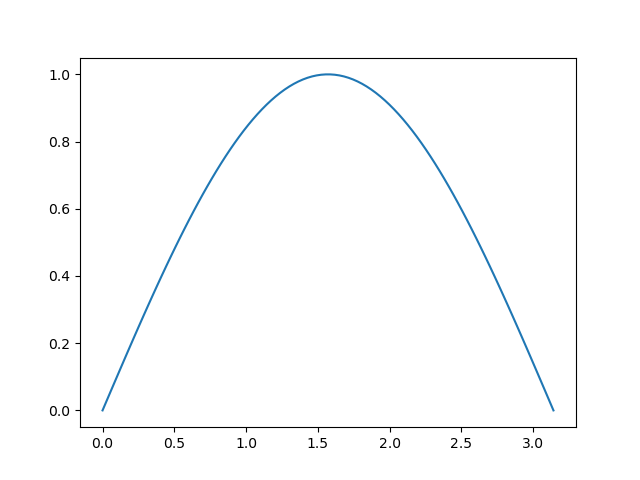

In [13]:
%matplotlib nbagg

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# create area for graphic
%timeit x = np.linspace(0, np.pi, 100)

# create function f(x) = sin(x)
%timeit y = (lambda x: np.sin(x))

# draw graphic
# Function to plot
plt.plot(x,y)

# function to show the plot
plt.show()

In [15]:
%matplotlib nbagg

import matplotlib
import matplotlib.pyplot as plt
import numpy
import dpnp as np

# create area for graphic
%timeit x = np.linspace(0.0, numpy.pi, 100, dtype=np.float32)

# create function f(x) = sin(x)
%timeit y = lambda x: np.sin(x)

# draw graphic
# Function to plot
plt.plot(x,y)

# function to show the plot
plt.show()

ValueError: Input of type <class 'numpy.float64'> could not be converted to numpy.ndarray

6. Example of Monte-Carlo approximation of sin(x) integral on 0:pi - TBD

In [3]:
import numpy as np

#number of points for Monte-Carlo approximation of sin(x) integral on 0:pi
ns = np.array([10, 100, 1000, 10000])

for n in ns:
    # create n uniform distributed points in rectangle (0:pi 0:1), that includes graph of sin(x) 
    %timeit data = np.random.uniform(low = (0, 0), high = (np.pi, 1), size = (n, 2))
 
    # count point if it fits inside area bounded by the function f(x)=sin(x)
    acc = 0

    for i in range(n):
        # Check the condition
        acc += data[(np.sin(data[i][0]) > data[i][1])].shape[0]
    
    # print the number of samples, Monte-Carlo approximation and difference with exact value (2)
    apprx = np.pi*acc/n
    print(n, apprx, 2-apprx)

7.39 µs ± 136 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
10 3.141592653589793 -1.1415926535897931
9.5 µs ± 100 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
100 2.0420352248333655 -0.042035224833365525
28.3 µs ± 422 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1000 2.0294688542190062 -0.029468854219006246
214 µs ± 5.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
10000 2.0096768205013906 -0.009676820501390626


In [1]:
import numpy
import os
# Call numpy ,if not null than we will use dpnp, by default not null
os.environ["DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK"] = "0"
import dpnp as np

# Expect result 0
print ("DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK =", np.config.__DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK__) 

# number of points for Monte-Carlo approximation of sin(x) integral on 0:pi
ns = np.array([10, 100, 1000, 10000])
print ("Result ns is located on the device:", ns.device)

for n in ns:
    # create n uniform distributed points in rectangle (0:pi 0:1), that includes graph of sin(x) 
    data = np.random.uniform(low = (0, 0), high = (numpy.pi, 1), size = (n, 2))
    print ("Result data is located on the device:", data.device)

    # count point if it fits inside area bounded by the function f(x)=sin(x)
    acc=0
 
    for i in range(int(n)):
        # Check the condition
        acc += data[(np.sin(data[i][0]) > data[i][1])].shape[0]
            
    # print the number of samples, Monte-Carlo approximation and difference with exact value (2)
    apprx = numpy.pi*acc/n
    # print ("Result apprx is located on the device:", apprx.device)
    print(n, apprx, 2-apprx)

DPNP_RAISE_EXCEPION_ON_NUMPY_FALLBACK = 0
Result ns is located on the device: Device(level_zero:gpu:0)
Result data is located on the device: Device(level_zero:gpu:0)
10 6.283185307179586 -4.283185307179586
Result data is located on the device: Device(level_zero:gpu:0)
100 6.283185307179586 -4.283185307179586
Result data is located on the device: Device(level_zero:gpu:0)
1000 6.283185307179586 -4.283185307179586
Result data is located on the device: Device(level_zero:gpu:0)
10000 6.283185307179586 -4.283185307179586


# dpctl simple examples

Here you may find a list of simple examples which explain how to understand how many devices you have in the systen and how to operate with them

In [5]:
# See the list of available SYCL platforms and extra metadata about each platform.
import dpctl

dpctl.lsplatform()  # Print platform information
dpctl.get_devices() # Get the list of all devices

Intel(R) OpenCL HD Graphics OpenCL 3.0 
Intel(R) Level-Zero 1.3
SYCL host platform 1.2


[<dpctl.SyclDevice [backend_type.opencl, device_type.gpu,  Intel(R) Iris(R) Xe Graphics] at 0x1a1eddcefb0>,
 <dpctl.SyclDevice [backend_type.level_zero, device_type.gpu,  Intel(R) Iris(R) Xe Graphics] at 0x1a1eca28f30>,
 <dpctl.SyclDevice [backend_type.host, device_type.host,  SYCL host device] at 0x1a1eddd73f0>]

In [3]:
# See the list of available gpu devices and their extra metadata.
import dpctl

if dpctl.has_gpu_devices():
    print (dpctl.get_devices(device_type='gpu'))
else:
    print("GPU device is not available")

[<dpctl.SyclDevice [backend_type.opencl, device_type.gpu,  Intel(R) Iris(R) Xe Graphics] at 0x1a1eddd72f0>, <dpctl.SyclDevice [backend_type.level_zero, device_type.gpu,  Intel(R) Iris(R) Xe Graphics] at 0x1a1eddd70f0>]


In [8]:
import dpctl

# Create a SyclDevice of type GPU based on whatever is returned
# by the SYCL `gpu_selector` device selector class.
gpu = dpctl.select_gpu_device()
gpu.print_device_info() # print GPU device information

    Name            Intel(R) Graphics [0x9a49]
    Driver version  1.2.0
    Vendor          Intel(R) Corporation
    Profile         FULL_PROFILE
    Filter string   level_zero:gpu:0



In [7]:
import dpctl

# Create a SyclDevice with an explicit filter string,
# in this case the first level_zero gpu device.
try:
    level_zero_gpu = dpctl.SyclDevice("level_zero:gpu:0")
    level_zero_gpu.print_device_info()
except:
    print("The first level_zero GPU device is not available")    

    Name            Intel(R) Iris(R) Xe Graphics
    Driver version  1.3.23904
    Vendor          Intel(R) Corporation
    Profile         FULL_PROFILE
    Filter string   level_zero:gpu:0

